# Modélisation du prix du m² à lille (année2022) pour les logements de 4 pièces, Séparation appartements vs maisons

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement , exploration et vérification des données 

In [11]:
# Configuration des graphiques
plt.style.use('default')
sns.set_palette('husl')

def load_and_explore_data():
    """ Charger les données de Lille"""
    print(" Chargement des données de Lille...")
    
    df = pd.read_csv("data/lille_2022.csv")
    print(f" Données chargées : {len(df)} transactions")
    
    # Explorer les colonnes disponibles
    print(" Colonnes disponibles :")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Vérifier les types de logements
    if 'Type local' in df.columns:
        print(f" Types de logements :")
        print(df['Type local'].value_counts())
    
    # Vérifier les nombres de pièces
    if 'Nombre pieces principales' in df.columns:
        print(f" Répartition nombre de pièces :")
        print(df['Nombre pieces principales'].value_counts().sort_index())
    
    return df

# Appel de  la fonction pour charger et explorer les données
df = load_and_explore_data()

 Chargement des données de Lille...
 Données chargées : 11354 transactions
 Colonnes disponibles :
   1. Identifiant de document
   2. Reference document
   3. 1 Articles CGI
   4. 2 Articles CGI
   5. 3 Articles CGI
   6. 4 Articles CGI
   7. 5 Articles CGI
   8. No disposition
   9. Date mutation
  10. Nature mutation
  11. Valeur fonciere
  12. No voie
  13. B/T/Q
  14. Type de voie
  15. Code voie
  16. Voie
  17. Code postal
  18. Commune
  19. Code departement
  20. Code commune
  21. Prefixe de section
  22. Section
  23. No plan
  24. No Volume
  25. 1er lot
  26. Surface Carrez du 1er lot
  27. 2eme lot
  28. Surface Carrez du 2eme lot
  29. 3eme lot
  30. Surface Carrez du 3eme lot
  31. 4eme lot
  32. Surface Carrez du 4eme lot
  33. 5eme lot
  34. Surface Carrez du 5eme lot
  35. Nombre de lots
  36. Code type local
  37. Type local
  38. Identifiant local
  39. Surface reelle bati
  40. Nombre pieces principales
  41. Nature culture
  42. Nature culture speciale
  43. Surf

## Filtrage des logements 4 pièces 

In [12]:
def filter_4_pieces_data(df):
    """ Filtrer les logements de 4 pièces"""
    print(" Filtrage des logements 4 pièces...")
    
    # Filtrer les 4 pièces
    df_4p = df[df['Nombre pieces principales'] == 4].copy()
    print(f" Logements 4 pièces : {len(df_4p)} transactions")
    
    if len(df_4p) == 0:
        print(" Aucun logement 4 pièces trouvé !")
        return None, None
    
    # Vérifier les types de logements dans les 4 pièces
    print(f" Types de logements 4 pièces :")
    print(df_4p['Type local'].value_counts())
    
    return(df_4p)
    #appel de la fonction
df_4p = filter_4_pieces_data(df)

   

 Filtrage des logements 4 pièces...
 Logements 4 pièces : 789 transactions
 Types de logements 4 pièces :
Type local
Appartement    435
Maison         354
Name: count, dtype: int64


## Séparation maisons /  appartements + fonction de néttoyage

In [13]:
from sklearn.model_selection import train_test_split  

#Créer les variables
appartements = df_4p[df_4p['Type local'] == 'Appartement'].copy()
maisons = df_4p[df_4p['Type local'] == 'Maison'].copy()

print(f" Appartements 4 pièces : {len(appartements)}")
print(f" Maisons 4 pièces : {len(maisons)}")

#   Définir la fonction de nettoyage
def select_features_and_clean(df, dataset_name):
    """Sélectionner les colonnes et nettoyer"""
    print(f" Nettoyage données {dataset_name}...")
    
    if len(df) == 0:
        print(f" Aucune donnée pour {dataset_name}")
        return None, None, None
    
    # Colonnes à conserver
    required_cols = ['Surface reelle bati', 'Nombre pieces principales', 'Type local', 'Valeur fonciere']
    optional_cols = ['Surface terrain', 'Nombre de lots']
    
    # Vérifier colonnes disponibles
    available_cols = [col for col in required_cols if col in df.columns]
    available_optional = [col for col in optional_cols if col in df.columns]
    
    print(f" Colonnes disponibles : {available_cols + available_optional}")
    
    # Sélectionner et nettoyer
    selected_cols = available_cols + available_optional
    df_clean = df[selected_cols].copy()
    
    # Créer prix_m2 (Variable cible)
    df_clean['prix_m2'] = df_clean['Valeur fonciere'] / df_clean['Surface reelle bati']
    print(f" Variable prix_m2 créée")
    
    # Nettoyage
    print(f" Avant nettoyage : {len(df_clean)} lignes")
    
    # Remplacer valeurs manquantes 
    if 'Surface terrain' in df_clean.columns:
        df_clean['Surface terrain'] = df_clean['Surface terrain'].fillna(0)
    if 'Nombre de lots' in df_clean.columns:
        df_clean['Nombre de lots'] = df_clean['Nombre de lots'].fillna(1)
    
    # Supprimer lignes avec données essentielles manquantes
    df_clean = df_clean.dropna(subset=['Surface reelle bati', 'Valeur fonciere'])
    print(f" Après nettoyage valeurs manquantes : {len(df_clean)} lignes")
    
    # Identifier et retirer les valeurs aberrantes (prix au m²)
    if len(df_clean) > 0:
        Q1 = df_clean['prix_m2'].quantile(0.25)
        Q3 = df_clean['prix_m2'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Limites pour les outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        print(f" Détection outliers prix_m2 :")
        print(f"   Q1: {Q1:.2f}, Q3: {Q3:.2f}")
        print(f"   Limites: [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        # Filtrer les outliers
        mask = (df_clean['prix_m2'] >= lower_bound) & (df_clean['prix_m2'] <= upper_bound)
        df_clean = df_clean[mask]
        
        print(f" Après suppression outliers : {len(df_clean)} lignes")
    
    if len(df_clean) == 0:
        print(f" Plus de données après nettoyage pour {dataset_name}")
        return None, None, None
    
    # Préparer X et y
    feature_cols = [col for col in df_clean.columns if col not in ['Valeur fonciere', 'prix_m2', 'Type local']]
    X = df_clean[feature_cols]
    y = df_clean['prix_m2']
        
    # Afficher quelques statistiques
    print(f"   Statistiques {dataset_name} :")
    print(f"   Prix m² min: {df_clean['prix_m2'].min():.2f} €")
    print(f"   Prix m² max: {df_clean['prix_m2'].max():.2f} €")
    print(f"   Prix m² moyen: {df_clean['prix_m2'].mean():.2f} €")
    print(f"   Variables : {list(X.columns)}")
    
    return X, y, df_clean

# Appeler la fonction
print("\n=== NETTOYAGE APPARTEMENTS ===")
X_apt, y_apt, df_apt_clean = select_features_and_clean(appartements, "APPARTEMENTS")

print("\n=== NETTOYAGE MAISONS ===")
X_maisons, y_maisons, df_maisons_clean = select_features_and_clean(maisons, "MAISONS")





 Appartements 4 pièces : 435
 Maisons 4 pièces : 354

=== NETTOYAGE APPARTEMENTS ===
 Nettoyage données APPARTEMENTS...
 Colonnes disponibles : ['Surface reelle bati', 'Nombre pieces principales', 'Type local', 'Valeur fonciere', 'Surface terrain', 'Nombre de lots']
 Variable prix_m2 créée
 Avant nettoyage : 435 lignes
 Après nettoyage valeurs manquantes : 435 lignes
 Détection outliers prix_m2 :
   Q1: 2617.08, Q3: 4310.38
   Limites: [77.12, 6850.34]
 Après suppression outliers : 386 lignes
   Statistiques APPARTEMENTS :
   Prix m² min: 416.67 €
   Prix m² max: 6824.32 €
   Prix m² moyen: 3352.36 €
   Variables : ['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain', 'Nombre de lots']

=== NETTOYAGE MAISONS ===
 Nettoyage données MAISONS...
 Colonnes disponibles : ['Surface reelle bati', 'Nombre pieces principales', 'Type local', 'Valeur fonciere', 'Surface terrain', 'Nombre de lots']
 Variable prix_m2 créée
 Avant nettoyage : 354 lignes
 Après nettoyage valeurs manq

## Division en jeu d'entraînement (80%) et test (20%) avec train_test_split

In [14]:
#  Division train/test 
if X_apt is not None:
    X_train_apt, X_test_apt, y_train_apt, y_test_apt = train_test_split(
        X_apt, y_apt, test_size=0.2, random_state=42
    )
    print(f" Appartements - Train: {len(X_train_apt)}, Test: {len(X_test_apt)}")

if X_maisons is not None:
    X_train_maisons, X_test_maisons, y_train_maisons, y_test_maisons = train_test_split(
        X_maisons, y_maisons, test_size=0.2, random_state=42
    )
    print(f" Maisons - Train: {len(X_train_maisons)}, Test: {len(X_test_maisons)}")

 Appartements - Train: 308, Test: 78
 Maisons - Train: 272, Test: 69


##  Corrèlations des variables avec le prix au m²

In [15]:

print(" Corrélations avec prix_m2:")

# Appartements
if df_apt_clean is not None:
    print(" APPARTEMENTS:")
    numeric_cols = df_apt_clean.select_dtypes(include=[np.number])
    print(numeric_cols.corr()['prix_m2'].sort_values(ascending=False))

# Maisons  
if df_maisons_clean is not None:
    print(" MAISONS:")
    numeric_cols = df_maisons_clean.select_dtypes(include=[np.number])
    print(numeric_cols.corr()['prix_m2'].sort_values(ascending=False))





 Corrélations avec prix_m2:
 APPARTEMENTS:
prix_m2                      1.000000
Valeur fonciere              0.816847
Surface reelle bati          0.281777
Surface terrain              0.129676
Nombre de lots               0.047431
Nombre pieces principales         NaN
Name: prix_m2, dtype: float64
 MAISONS:
prix_m2                      1.000000
Valeur fonciere              0.754197
Surface terrain              0.142383
Nombre de lots              -0.044690
Surface reelle bati         -0.053308
Nombre pieces principales         NaN
Name: prix_m2, dtype: float64


## Standardisation (uniquement pour x ) et entrainement du modèle 

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Pour les appartements
if X_train_apt is not None:
    scaler_apt = StandardScaler()
    X_train_apt_scaled = scaler_apt.fit_transform(X_train_apt)
    X_test_apt_scaled = scaler_apt.transform(X_test_apt)

# Pour les maisons
if X_train_maisons is not None:
    scaler_maisons = StandardScaler()
    X_train_maisons_scaled = scaler_maisons.fit_transform(X_train_maisons)
    X_test_maisons_scaled = scaler_maisons.transform(X_test_maisons)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Pour les appartements
if X_train_apt is not None:
    scaler_apt = StandardScaler()
    X_train_apt_scaled = scaler_apt.fit_transform(X_train_apt)
    X_test_apt_scaled = scaler_apt.transform(X_test_apt)

# Pour les maisons
if X_train_maisons is not None:
    scaler_maisons = StandardScaler()
    X_train_maisons_scaled = scaler_maisons.fit_transform(X_train_maisons)
    X_test_maisons_scaled = scaler_maisons.transform(X_test_maisons)

# Pour les appartements
if X_train_apt_scaled is not None:
    print(" Entraînement Régression Linéaire - APPARTEMENTS")
    model_apt = LinearRegression()
    model_apt.fit(X_train_apt_scaled, y_train_apt)  
    
    # Prédictions
    y_pred_apt = model_apt.predict(X_test_apt_scaled)
    
    # Évaluation
    mse_apt = mean_squared_error(y_test_apt, y_pred_apt)
    print(f"   MSE: {mse_apt:.2f}")

#Entrainement
# Pour les maisons
if X_train_maisons_scaled is not None:
    print(" Entraînement Régression Linéaire - MAISONS")
    model_maisons = LinearRegression()
    model_maisons.fit(X_train_maisons_scaled, y_train_maisons)  
    
    # Prédictions
    y_pred_maisons = model_maisons.predict(X_test_maisons_scaled)
    
    # Évaluation
    mse_maisons = mean_squared_error(y_test_maisons, y_pred_maisons)
    print(f"   MSE: {mse_maisons:.2f}")




 Entraînement Régression Linéaire - APPARTEMENTS
   MSE: 1495078.04
 Entraînement Régression Linéaire - MAISONS
   MSE: 607924.10


## Modèle de régréssion linéaire 



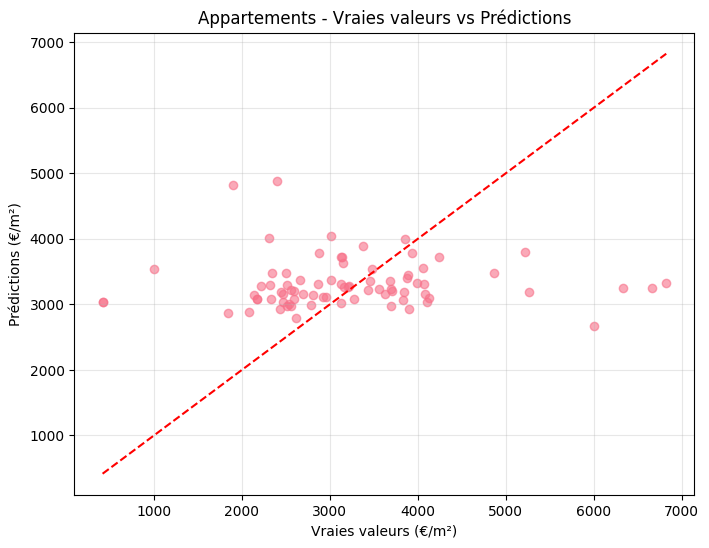

In [18]:
import matplotlib.pyplot as plt

 # Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test_apt, y_pred_apt, alpha=0.6)
plt.plot([y_test_apt.min(), y_test_apt.max()], 
            [y_test_apt.min(), y_test_apt.max()], 
            color="red", linestyle="--")
plt.xlabel("Vraies valeurs (€/m²)")
plt.ylabel("Prédictions (€/m²)")
plt.title("Appartements - Vraies valeurs vs Prédictions")
plt.grid(True, alpha=0.3)
plt.show()


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

print("Régression Linéaire...")

# Pour les appartements
if 'X_train_apt_scaled' in locals():
    print(" APPARTEMENTS")
    lr_apt = LinearRegression()
    lr_apt.fit(X_train_apt_scaled, y_train_apt)  
    y_pred_lr_apt = lr_apt.predict(X_test_apt_scaled)
    mse_lr_apt = mean_squared_error(y_test_apt, y_pred_lr_apt)
    print(f" MSE: {mse_lr_apt:.2f}")

# Pour les maisons
if 'X_train_maisons_scaled' in locals():
    print(" MAISONS")
    lr_maisons = LinearRegression()
    lr_maisons.fit(X_train_maisons_scaled, y_train_maisons)  
    y_pred_lr_maisons = lr_maisons.predict(X_test_maisons_scaled)
    mse_lr_maisons = mean_squared_error(y_test_maisons, y_pred_lr_maisons)
    print(f" MSE: {mse_lr_maisons:.2f}")

Régression Linéaire...
 APPARTEMENTS
 MSE: 1495078.04
 MAISONS
 MSE: 607924.10


## Modèle décision threeregressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

print(" DECISION TREE REGRESSOR")
print("=" * 40)

# Pour les appartements
if 'X_train_apt_scaled' in locals():
    print(" APPARTEMENTS - Decision Tree")
    dt_apt = DecisionTreeRegressor(random_state=42)
    dt_apt.fit(X_train_apt_scaled, y_train_apt)
    y_pred_dt_apt = dt_apt.predict(X_test_apt_scaled)
    mse_dt_apt = mean_squared_error(y_test_apt, y_pred_dt_apt)
    print(f"   MSE: {mse_dt_apt:.2f}")

# Pour les maisons
if 'X_train_maisons_scaled' in locals():
    print(" MAISONS - Decision Tree")
    dt_maisons = DecisionTreeRegressor(random_state=42)
    dt_maisons.fit(X_train_maisons_scaled, y_train_maisons)
    y_pred_dt_maisons = dt_maisons.predict(X_test_maisons_scaled)
    mse_dt_maisons = mean_squared_error(y_test_maisons, y_pred_dt_maisons)
    print(f"   MSE: {mse_dt_maisons:.2f}")

 DECISION TREE REGRESSOR
 APPARTEMENTS - Decision Tree
   MSE: 1896274.98
 MAISONS - Decision Tree
   MSE: 1259491.71


In [ ]:
from sklearn.ensemble import RandomForestRegressor


print("\n RANDOM FOREST REGRESSOR")
print("=" * 40)

# Pour les appartements
if 'X_train_apt_scaled' in locals():
    print(" APPARTEMENTS - Random Forest")
    rf_apt = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_apt.fit(X_train_apt_scaled, y_train_apt)
    y_pred_rf_apt = rf_apt.predict(X_test_apt_scaled)
    mse_rf_apt = mean_squared_error(y_test_apt, y_pred_rf_apt)
    print(f"   MSE: {mse_rf_apt:.2f}")

# Pour les maisons
if 'X_train_maisons_scaled' in locals():
    print("MAISONS - Random Forest")
    rf_maisons = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_maisons.fit(X_train_maisons_scaled, y_train_maisons)
    y_pred_rf_maisons = rf_maisons.predict(X_test_maisons_scaled)
    mse_rf_maisons = mean_squared_error(y_test_maisons, y_pred_rf_maisons)
    print(f"   MSE: {mse_rf_maisons:.2f}")





